## Import Relevant Libraries

In [1]:
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

## Define Currency

In [2]:
crypto_currency = 'ETH'
againts_currency = 'USD'

## Define Time

In [3]:
start = dt.datetime(2015,1,1)
end = dt.datetime.now()

## Get the actual data

In [4]:
data = web.DataReader(f'{crypto_currency}-{againts_currency}', 'yahoo', start, end)

## Show the Data

In [5]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-11-09,329.451996,307.056000,308.644989,320.884003,893249984,320.884003
2017-11-10,324.717987,294.541992,320.670990,299.252991,885985984,299.252991
2017-11-11,319.453003,298.191986,298.585999,314.681000,842300992,314.681000
2017-11-12,319.153015,298.513000,314.690002,307.907990,1613479936,307.907990
2017-11-13,328.415009,307.024994,307.024994,316.716003,1041889984,316.716003


## Prepare Data

## Use scaler to squeeze the value between 0 and 1

In [6]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

## Determine the predicted days

In [7]:
prediction_days = 60
future_day = 0

# Prepare the training data

In [8]:
x_train, y_train = [], []

## Fill it with actual values

In [9]:
import numpy as np

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create the neural network

In [10]:
model = Sequential()

model.add(LSTM(units=50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
52/52 [==============================] - 6s 42ms/step - loss: 0.0125
Epoch 2/25
52/52 [==============================] - 2s 41ms/step - loss: 0.0042
Epoch 3/25
52/52 [==============================] - 2s 42ms/step - loss: 0.0035
Epoch 4/25
52/52 [==============================] - 2s 42ms/step - loss: 0.0031
Epoch 5/25
52/52 [==============================] - 2s 42ms/step - loss: 0.0028
Epoch 6/25
52/52 [==============================] - 2s 41ms/step - loss: 0.0028
Epoch 7/25
52/52 [==============================] - 2s 42ms/step - loss: 0.0037
Epoch 8/25
52/52 [==============================] - 2s 45ms/step - loss: 0.0026
Epoch 9/25
52/52 [==============================] - 2s 46ms/step - loss: 0.0025
Epoch 10/25
52/52 [==============================] - 2s 45ms/step - loss: 0.0022
Epoch 11/25
52/52 [==============================] - 3s 48ms/step - loss: 0.0021
Epoch 12/25
52/52 [==============================] - 3s 48ms/step - loss: 0.0023
Epoch 13/25
52/52 [==================

## Testing the Model

In [11]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{againts_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [12]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

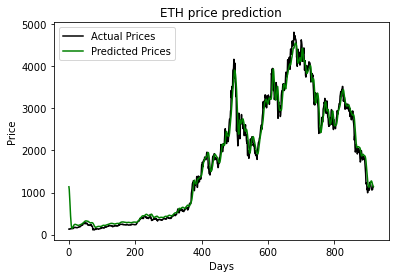

In [13]:
import matplotlib.pyplot as plt

plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()